In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PSSimPy.simulator import BasicSim
from PSSimPy.constraint_handler import MinBalanceConstraintHandler
from PSSimPy.queues import FIFOQueue
from PSSimPy.credit_facilities import SimplePriced
from PSSimPy.transaction_fee import FixedTransactionFee

sns.set_theme(style="whitegrid")

In [23]:
import os
for file in os.listdir():
    if file.endswith(".csv"):
        os.remove(file)

# Simulation

### Simulation Data

In [24]:
NUM_DAYS = 100
OPEN_TIME = '08:00'
CLOSE_TIME = '12:00'
BANK_FAILURE =  {3:[('09:00', 'b1')], 10: [('11:00', 'b2')]}

from transaction_generator import *
banks, accounts, transactions = generate_random_transactions(num_days=NUM_DAYS,
                                                             open_time=OPEN_TIME,
                                                             close_time=CLOSE_TIME,
                                                             num_banks=7,
                                                             num_big_banks=3,
                                                             min_bal=100,
                                                             max_bal=200,
                                                             min_txn_count=15,
                                                             max_txn_count=20,
                                                             min_txn_value=200,
                                                             max_txn_value=300,
                                                             seed=1234)

In [25]:
# NUM_DAYS = 1
# OPEN_TIME = '08:00'
# CLOSE_TIME = '09:00'
# BANK_FAILURE =  {1:[('08:15', 'b1')]}

# banks = {'name': ['b1', 'b2', 'b3'], 'bank_code': ['Bank 1', 'Bank 2', 'Bank 3']}
# accounts = {'id': ['acc1', 'acc2', 'acc3'], 'owner': ['b1', 'b2', 'b3'], 'balance': [25, 25, 25]}
# transactions = pd.DataFrame([
#     {'time': '08:00', 'sender_account': 'acc1', 'receipient_account': 'acc2', 'amount': 30},
#     {'time': '08:00', 'sender_account': 'acc2', 'receipient_account': 'acc3', 'amount': 30},
#     {'time': '08:00', 'sender_account': 'acc3', 'receipient_account': 'acc1', 'amount': 30},
#     {'time': '08:15', 'sender_account': 'acc1', 'receipient_account': 'acc2', 'amount': 30},
#     {'time': '08:15', 'sender_account': 'acc2', 'receipient_account': 'acc3', 'amount': 30},
#     {'time': '08:15', 'sender_account': 'acc3', 'receipient_account': 'acc1', 'amount': 30},
#     {'time': '08:30', 'sender_account': 'acc1', 'receipient_account': 'acc2', 'amount': 30},
#     {'time': '08:30', 'sender_account': 'acc2', 'receipient_account': 'acc3', 'amount': 30},
#     {'time': '08:30', 'sender_account': 'acc3', 'receipient_account': 'acc1', 'amount': 30},
#     {'time': '08:45', 'sender_account': 'acc1', 'receipient_account': 'acc2', 'amount': 30},
#     {'time': '08:45', 'sender_account': 'acc2', 'receipient_account': 'acc3', 'amount': 30},
#     {'time': '08:45', 'sender_account': 'acc3', 'receipient_account': 'acc1', 'amount': 30},
# ])

### Simulation in a Normal Condition

In [26]:
sim_normal = BasicSim(name = 'sim-normal',
                      banks = banks,
                      accounts = accounts,
                      transactions = transactions,
                      num_days=NUM_DAYS,
                      open_time = OPEN_TIME,
                      close_time = CLOSE_TIME,
                      constraint_handler = MinBalanceConstraintHandler(0),
                      queue = FIFOQueue(),
                      credit_facility = SimplePriced(),
                      transaction_fee_handler = FixedTransactionFee())
sim_normal.run()

### Simulation with a Bank Failure

In [27]:
sim_stress = BasicSim(name = 'sim-stress',
                      banks = banks,
                      accounts = accounts,
                      transactions = transactions,
                      num_days=NUM_DAYS,
                      open_time = OPEN_TIME,
                      close_time = CLOSE_TIME,
                      bank_failure = BANK_FAILURE,
                      constraint_handler = MinBalanceConstraintHandler(0),
                      queue = FIFOQueue(),
                      credit_facility = SimplePriced(),
                      transaction_fee_handler = FixedTransactionFee())
sim_stress.run()

# Analysis

### Transactions

In [28]:
tran_normal = pd.read_csv('sim-normal-processed_transactions.csv')
tran_stress = pd.read_csv('sim-stress-processed_transactions.csv')

In [29]:
tran_normal.head()

,day,time,from_account,to_account,amount,status
0,1,08:00,acc4,acc5,282,Success
1,1,08:00,acc3,acc6,257,Success
2,1,08:00,acc3,acc4,229,Success
3,1,08:00,acc2,acc7,254,Success
4,1,08:00,acc2,acc3,288,Success


In [30]:
tran_stress.head()

,day,time,from_account,to_account,amount,status
0,1,08:00,acc4,acc1,287,Success
1,1,08:00,acc3,acc6,232,Success
2,1,08:00,acc6,acc2,276,Success
3,1,08:00,acc4,acc3,291,Success
4,1,08:00,acc4,acc2,236,Success


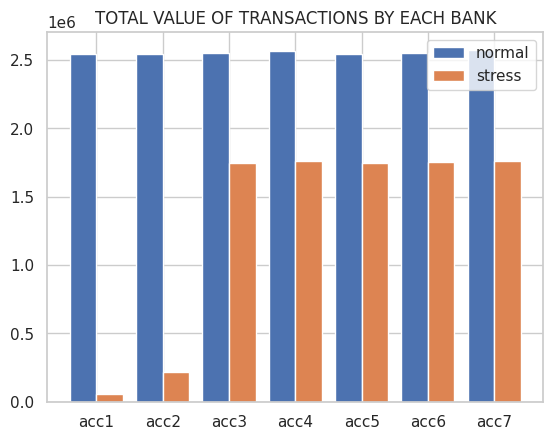

In [31]:
txn_value_normal = tran_normal[tran_normal['status'] == 'Success'].groupby('to_account')['amount'].sum()
txn_value_stress = tran_stress[tran_stress['status'] == 'Success'].groupby('to_account')['amount'].sum()

index = np.arange(len(txn_value_normal))
bar_width = 0.4

plt.bar(index, txn_value_normal, bar_width, label='normal')
plt.bar(index + bar_width, txn_value_stress, bar_width, label='stress')
plt.xticks(index + bar_width / 2, txn_value_normal.index)
plt.title('TOTAL VALUE OF TRANSACTIONS BY EACH BANK')
plt.legend()
plt.show()

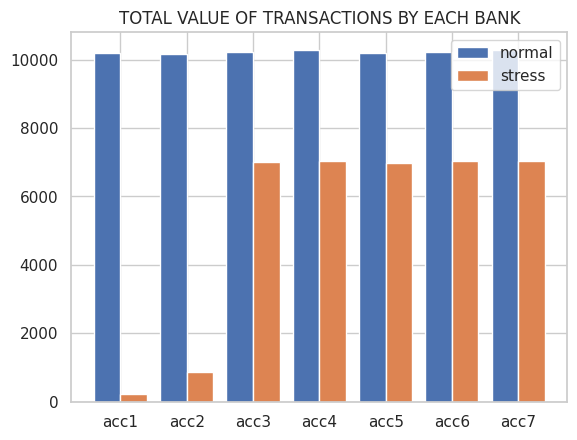

In [32]:
txn_volume_normal = tran_normal[tran_normal['status'] == 'Success'].groupby('to_account')['amount'].count()
txn_volume_stress = tran_stress[tran_stress['status'] == 'Success'].groupby('to_account')['amount'].count()

index = np.arange(len(txn_volume_normal))
bar_width = 0.4

plt.bar(index, txn_volume_normal, bar_width, label='normal')
plt.bar(index + bar_width, txn_volume_stress, bar_width, label='stress')
plt.xticks(index + bar_width / 2, txn_volume_normal.index)
plt.title('TOTAL VALUE OF TRANSACTIONS BY EACH BANK')
plt.legend()
plt.show()

In [33]:
first_fail_index = (tran_stress['status'] == 'Failed').idxmax()
tran_stress.iloc[first_fail_index:].head(5)

,day,time,from_account,to_account,amount,status
1615,3,09:00,acc5,acc1,257,Failed
1616,3,09:00,acc1,acc2,258,Failed
1617,3,09:00,acc2,acc1,237,Failed
1618,3,09:00,acc7,acc1,217,Failed
1619,3,09:00,acc1,acc4,259,Failed


### Balance

In [34]:
import re

blnc_normal = pd.read_csv('sim-normal-account_balance.csv')
blnc_normal = blnc_normal.pivot(index=['day', 'time'], columns=['account'], values=['balance'])
blnc_normal.columns = blnc_normal.columns.to_flat_index().str.join('_')
blnc_normal.columns = blnc_normal.columns.map(lambda c: re.sub('_$', '', c))
blnc_normal = blnc_normal.reset_index()
blnc_normal.head()

,day,time,balance_acc1,balance_acc2,balance_acc3,balance_acc4,balance_acc5,balance_acc6,balance_acc7
0,1,08:00,821.0,974.0,1305.0,992.0,2122.0,1827.0,1483.0
1,1,08:15,2345.0,1184.0,1782.0,1051.0,1264.0,2827.0,2285.0
2,1,08:30,1654.0,1919.0,2461.0,1561.0,1497.0,3829.0,1208.0
3,1,08:45,2222.0,2080.0,1169.0,578.0,3362.0,4807.0,2381.0
4,1,09:00,2478.0,2672.0,2768.0,1448.0,2423.0,4228.0,2443.0


In [35]:
blnc_stress = pd.read_csv('sim-stress-account_balance.csv')
blnc_stress = blnc_stress.pivot(index=['day', 'time'], columns=['account'], values=['balance'])
blnc_stress.columns = blnc_stress.columns.to_flat_index().str.join('_')
blnc_stress.columns = blnc_stress.columns.map(lambda c: re.sub('_$', '', c))
blnc_stress = blnc_stress.reset_index()

# replace balance of failed banks into 0
blnc_stress.loc[(blnc_stress['day']>=1) & (blnc_stress['time']>='09:00'), 'balance_acc1'] = 0

blnc_stress.head()

,day,time,balance_acc1,balance_acc2,balance_acc3,balance_acc4,balance_acc5,balance_acc6,balance_acc7
0,1,08:00,821.0,974.0,1305.0,992.0,2122.0,1827.0,1483.0
1,1,08:15,2345.0,1184.0,1782.0,1051.0,1264.0,2827.0,2285.0
2,1,08:30,1654.0,1919.0,2461.0,1561.0,1497.0,3829.0,1208.0
3,1,08:45,2222.0,2080.0,1169.0,578.0,3362.0,4807.0,2381.0
4,1,09:00,0.0,2672.0,2768.0,1448.0,2423.0,4228.0,2443.0


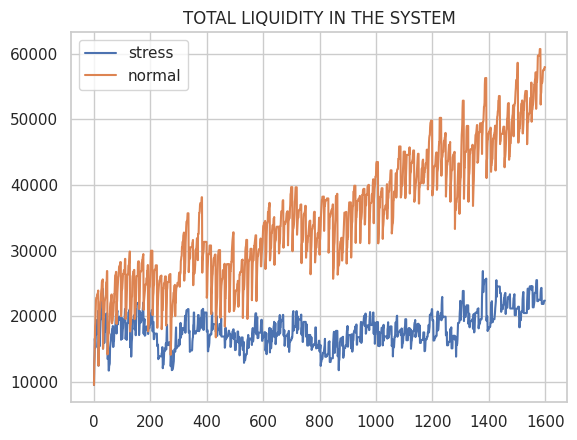

In [36]:
total_liquidity_stress = blnc_stress.loc[:, blnc_stress.columns.difference(['day', 'time'])].sum(axis=1)
total_liquidity_normal = blnc_normal.loc[:, blnc_normal.columns.difference(['day', 'time'])].sum(axis=1)

plt.plot(total_liquidity_stress, label='stress')
plt.plot(total_liquidity_normal, label='normal')
plt.title('TOTAL LIQUIDITY IN THE SYSTEM')
plt.legend()
plt.show()

### Credit Facility

In [37]:
cred_normal = pd.read_csv('sim-normal-credit_facility.csv')
cred_stress = pd.read_csv('sim-stress-credit_facility.csv')

In [38]:
cred_normal.head()

,day,time,account,posted_collateral,total_credit,total_fee
0,1,08:00,acc1,0,1059.0,0.0
1,1,08:00,acc2,0,87.0,0.0
2,1,08:00,acc3,0,1300.0,0.0
3,1,08:00,acc4,0,2284.0,0.0
4,1,08:00,acc5,0,64.0,0.0


In [39]:
cred_stress.head()

,day,time,account,posted_collateral,total_credit,total_fee
0,1,08:00,acc1,0,1059.0,0.0
1,1,08:00,acc2,0,87.0,0.0
2,1,08:00,acc3,0,1300.0,0.0
3,1,08:00,acc4,0,2284.0,0.0
4,1,08:00,acc5,0,64.0,0.0


In [40]:
total_credit_normal = cred_normal.groupby(['day', 'time']).sum('total_credit')['total_credit'].cumsum().values
total_credit_stress = cred_stress.groupby(['day', 'time']).sum('total_credit')['total_credit'].cumsum().values

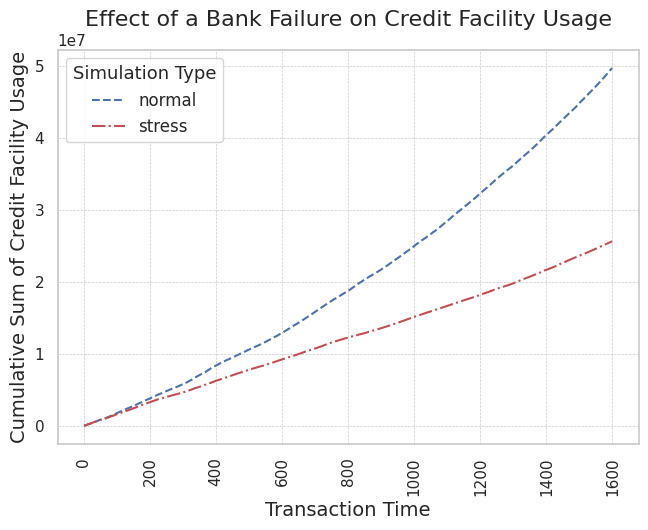

In [41]:
plt.plot(total_credit_normal, '--b', label='normal')
plt.plot(total_credit_stress, '-.r', label='stress')
plt.title('CREDIT FACILITY USAGE')
plt.legend(title='Simulation Type', title_fontsize='13', fontsize='12', loc='upper left')

plt.tight_layout()
plt.title(f'Effect of a Bank Failure on Credit Facility Usage', fontsize=16)
plt.xlabel('Transaction Time', fontsize=14)
plt.ylabel('Cumulative Sum of Credit Facility Usage', fontsize=14)
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [42]:
# find first index of failed bank
cred_stress.loc[(cred_stress['day'] >= 5) & (cred_stress['time'] >= '09:00'), :]

,day,time,account,posted_collateral,total_credit,total_fee
476,5,09:00,acc1,0,0.0,0.0
477,5,09:00,acc2,0,5905.0,0.0
478,5,09:00,acc3,0,1634.0,0.0
479,5,09:00,acc4,0,110.0,0.0
480,5,09:00,acc5,0,0.0,0.0
...,...,...,...,...,...,...
11195,100,11:45,acc3,0,14440.0,0.0
11196,100,11:45,acc4,0,341.0,0.0
11197,100,11:45,acc5,0,0.0,0.0
11198,100,11:45,acc6,0,5347.0,0.0
